In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from skimage import transform
import cv2

%matplotlib inline

In [2]:
env = gym.make("Tennis-v0")

In [3]:
env.reset()
for count in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()
env.close()

In [4]:
print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space.n))

Observation Space: Box(250, 160, 3)
Action Space: 18


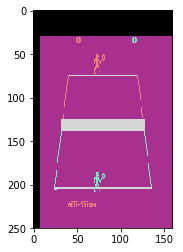

In [5]:
img = env.reset()
plt.imshow(img)

In [6]:
def preprocessing(frame):
    newframe = frame[45:215,15:150]
#     print(newframe.shape)
    newframe = cv2.cvtColor(newframe, cv2.COLOR_BGR2GRAY)
    newframe = newframe/255.0
    
    newframe = transform.resize(newframe, [84,84])
    return newframe, newframe.shape

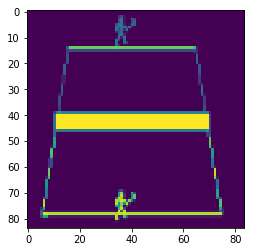

In [7]:
newimg = preprocessing(img)[0]
plt.imshow(newimg)
obs_size = preprocessing(img)[1]


In [8]:
# Stacking frames
stack_size = 4
stacked_frames= deque([np.zeros((84, 84), dtype = np.uint8) for i in range(stack_size)], maxlen = 4)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocessing(state)[0]
    if is_new_episode:
        # Reinitialize with 4 repeated frames
        for _ in range(4):
            stacked_frames.append(frame)
    else:
        # Just append the new frame(The last frame will get removed)
        stacked_frames.append(frame)
    
    # Converting Frames Deque to numpy.stack
    stacked_state = np.stack(stacked_frames, axis = 2)
    return stacked_state, stacked_frames

In [9]:
def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)

    return discounted_episode_rewards

In [10]:
# Hyper-parameters
alpha = 0.0001
gamma = 0.99
num_epochs = 1000  # Total epochs for training 
batch_size = 1000 # Each 1 is a timestep (NOT AN EPISODE) --- Just one SARSA tuple

state_size = [*obs_size,4]
stack_size = 4
action_size = env.action_space.n
training = True

In [17]:
class PGNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='PGNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                # We create the placeholders
                # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
                # [None, 84, 84, 4]
                self.inputs_= tf.placeholder(tf.float32, [None, *state_size], name="inputs_")
                self.actions = tf.placeholder(tf.int32, [None, action_size], name="actions")
                self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None, ], name="discounted_episode_rewards_")
            
                
                # Add this placeholder for having this variable in tensorboard
                self.mean_reward_ = tf.placeholder(tf.float32, name="mean_reward")
                
            with tf.name_scope("conv1"):
                """
                First convnet:
                CNN
                BatchNormalization
                ELU
                """
                # Input is 84x84x4
                self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                             filters = 32,
                                             kernel_size = [8,8],
                                             strides = [4,4],
                                             padding = "VALID",
                                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                             name = "conv1")

                self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm1')

                self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
                ## --> [20, 20, 32]
            
            with tf.name_scope("conv2"):
                """
                Second convnet:
                CNN
                BatchNormalization
                ELU
                """
                self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                     filters = 64,
                                     kernel_size = [4,4],
                                     strides = [2,2],
                                     padding = "VALID",
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                     name = "conv2")

                self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm2')

                self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
                ## --> [9, 9, 64]
            
            with tf.name_scope("conv3"):
                """
                Third convnet:
                CNN
                BatchNormalization
                ELU
                """
                self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                     filters = 128,
                                     kernel_size = [4,4],
                                     strides = [2,2],
                                     padding = "VALID",
                                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                     name = "conv3")

                self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                       training = True,
                                                       epsilon = 1e-5,
                                                         name = 'batch_norm3')

                self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
                ## --> [3, 3, 128]
            
            with tf.name_scope("flatten"):
                self.flatten = tf.layers.flatten(self.conv3_out)
                ## --> [1152]
            
            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.flatten,
                                      units = 512,
                                      activation = tf.nn.elu,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                    name="fc1")
            
            with tf.name_scope("logits"):
                self.logits = tf.layers.dense(inputs = self.fc, 
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                              units = action_size, 
                                            activation=None)
            
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)
                

            with tf.name_scope("loss"):
                # tf.nn.softmax_cross_entropy_with_logits computes the cross entropy of the result after applying the softmax function
                # If you have single-class labels, where an object can only belong to one class, you might now consider using 
                # tf.nn.sparse_softmax_cross_entropy_with_logits so that you don't have to convert your labels to a dense one-hot array. 
                self.neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, labels = self.actions)
                self.loss = tf.reduce_mean(self.neg_log_prob * self.discounted_episode_rewards_) 
        
    
            with tf.name_scope("train"):
                self.train_opt = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [18]:
import tensorflow as tf
# Reset the graph
tf.reset_default_graph()

# Instantiate the PGNetwork
PGNetwork = PGNetwork(state_size, action_size, alpha)

# Initialize Session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [1]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/tensorboard/pg/test")

## Losses
tf.summary.scalar("Loss", PGNetwork.loss)

## Reward mean
tf.summary.scalar("Reward_mean", PGNetwork.mean_reward_ )

write_op = tf.summary.merge_all()

NameError: name 'tf' is not defined

In [19]:
import random

In [20]:
def make_batch(batch_size, stacked_frames):
    states = []
    actions = []
    rewards_of_batch = [] 
    discounted_rewards = []
    rewards_of_episode = []
    episode_num = 1 #Initialising episode count
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    
    while True:
        action_prob_dist = sess.run(PGNetwork.action_distribution, feed_dict = {PGNetwork.inputs_: state.reshape(1, *state_size)})
        # Accounting for Stochastic Policy
        chosen_action = random.randint(0,action_size-1)
        action_num = np.random.choice(range(action_prob_dist.shape[1]), 
                                  p=action_prob_dist.ravel())
        action_tup = np.zeros(action_size)
        action_tup[action_num] = 1
        
        next_state, reward, done, info = env.step(action_num)
        
        # STORE
        states.append(state)
        actions.append(action_tup)
        rewards_of_episode.append(reward)
        
        if done:
            next_state = np.zeros((250, 160, 3), dtype=np.uint8)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            
            rewards_of_batch.append(rewards_of_episode)
            # Calculate gamma Gt
            discounted_rewards.append(discount_and_normalize_rewards(rewards_of_episode))
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
                
            # Reset the transition stores
            rewards_of_episode = []
            
            # Add episode
            episode_num += 1
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            
        else:
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
    
    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), episode_num


In [ ]:
# Keep track of all rewards total for each batch
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
epoch = 1
average_reward = []

# Saver
saver = tf.train.Saver()

if training:
    # Load the model
    #saver.restore(sess, "./models/model.ckpt")

    while epoch < num_epochs + 1:
        # Gather training data
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(batch_size, stacked_frames)

        ### These part is used for analytics
        # Calculate the total reward ot the batch
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        allRewards.append(total_reward_of_that_batch)

        # Calculate the mean reward of the batch
        # Total rewards of batch / nb episodes in that batch
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)

        # Calculate the average reward of all training
        # mean_reward_of_that_batch / epoch
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)

        # Calculate maximum reward recorded 
        maximumRewardRecorded = np.amax(allRewards)

        print("==========================================")
        print("Epoch: ", epoch, "/", num_epochs)
        print("-----------")
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward: {}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        # Feedforward, gradient and backpropagation
        loss_, _ = sess.run([PGNetwork.loss, PGNetwork.train_opt], feed_dict={PGNetwork.inputs_: states_mb.reshape((len(states_mb), 84,84,4)),
                                                            PGNetwork.actions: actions_mb,
                                                                     PGNetwork.discounted_episode_rewards_: discounted_rewards_mb 
                                                                    })

        print("Training Loss: {}".format(loss_))

        # Write TF Summaries
        summary = sess.run(write_op, feed_dict={PGNetwork.inputs_: states_mb.reshape((len(states_mb), 84, 84, 4)),
                                                            PGNetwork.actions: actions_mb,
                                                                     PGNetwork.discounted_episode_rewards_: discounted_rewards_mb,
                                                                    PGNetwork.mean_reward_: mean_reward_of_that_batch
                                                                    })

        #summary = sess.run(write_op, feed_dict={x: s_.reshape(len(s_),84,84,1), y:a_, d_r: d_r_, r: r_, n: n_})
        writer.add_summary(summary, epoch)
        writer.flush()

        # Save Model
        if epoch % 10 == 0:
            saver.save(sess, "./models/model.ckpt")
            print("Model saved")
        epoch += 1

In [ ]:
# Saver
saver = tf.train.Saver()

with tf.Session() as sess:
    state = env.reset()
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    
    for i in range(10):
        total_reward = 0
        # Launch a new episode
        state = env.reset()
        # Get a new state
        state, stacked_frames = stack_frames(stacked_frames, state, True)

        while True:
        
            # Run State Through Policy & Calculate Action
            action_probability_distribution = sess.run(PGNetwork.action_distribution, 
                                                       feed_dict={PGNetwork.inputs_: state.reshape(1, *state_size)})

            # REMEMBER THAT WE ARE IN A STOCHASTIC POLICY SO WE DON'T ALWAYS TAKE THE ACTION WITH THE HIGHEST PROBABILITY
            # (For instance if the action with the best probability for state S is a1 with 70% chances, there is
            #30% chance that we take action a2)
            action = np.random.choice(range(action_probability_distribution.shape[1]), 
                                      p=action_probability_distribution.ravel())  # select action w.r.t the actions prob
            # action = possible_actions[action]

            # Perform action
            next_state, reward, done, info = env.step(action)
            total_reward+=reward
            plt.imshow(next_state)
            if done:
                break
            else:
                # If not done, the next_state become the current state
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state
        

        print("Score for episode ", i, " :", total_reward)